In [2]:
## the data directory
datadir = '../Datasets/'

## location of the GED code
## use the '-S' option to use split JS divergence
GED = 'C:\\Users\\siddbist\\Downloads\\GraphMiningNotebooks-master\\GraphMiningNotebooks-master\\GED\\GED'

## location of the node2vec code
n2v = 'C:\\Users\\siddbist\\Downloads\\GraphMiningNotebooks-master\\GraphMiningNotebooks-master\\Snap-6.0-Win32\\node2vec.exe'


In [35]:
import igraph as ig
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression
from collections import Counter
import os
import umap.umap_ as umap
import pickle
import partition_igraph
import subprocess
import scipy.sparse.linalg as lg
from sklearn.cluster import KMeans, DBSCAN
from sklearn.model_selection import train_test_split
from sklearn.metrics import adjusted_mutual_info_score as AMI
from sklearn.metrics import adjusted_rand_score as ARI
from graphrole import RecursiveFeatureExtractor, RoleExtractor
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import calinski_harabasz_score as CHS
from sklearn.metrics import silhouette_score as SIL
%config Completer.use_jedi = False

## node and edge greyscale colors
cls_edges = 'gainsboro'
cls = ['silver','dimgray','black']

In [5]:
## as defined in the node2vec paper
def binary_operator(u, v, op='had'):
    if op=='had':
        return u * v
    if op=='l1':
        return np.abs(u - v)
    if op=='l2':
        return (u - v) ** 2
    if op=='avg':
        return (u + v) / 2.0
    
def readEmbedding(fn="_embed", N2K=None):
    D = pd.read_csv(fn, sep=' ', skiprows=1, header=None)
    D = D.dropna(axis=1)
    if N2K!=None:
        x = [N2K[i] for i in D[0]]
        D[0] = x    
        D = D.sort_values(by=0)
    Y = np.array(D.iloc[:,1:])
    return Y

## Read embedding from file in node2vec format
## Map to layout format
## for visualization, we use UMAP if dim > 2
def embed2layout(fn="_embed"):
    D = pd.read_csv(fn, sep=' ', skiprows=1, header=None)
    D = D.dropna(axis=1)
    D = D.sort_values(by=0)
    Y = np.array(D.iloc[:,1:])
    if Y.shape[1]>2:
        Y = umap.UMAP().fit_transform(Y)
    ly = []
    for v in range(Y.shape[0]):
        ly.append((Y[v][0],Y[v][1]))
    return ly


## Computing JS divergence with GED code given edgelist, communities and embedding
def JS(edge_file, comm_file, embed_file, entropy=False):
    if entropy:
        x = GED+' -E -g '+edge_file+' -c '+comm_file+' -e '+embed_file
    else:
        x = GED+' -g '+edge_file+' -c '+comm_file+' -e '+embed_file
    s = subprocess.run(x, shell=True, stdout=subprocess.PIPE)
    x = s.stdout.decode().split(' ')
    print(x)
    div = float(x[1])
    return(div)


## Hope embedding with various similarity functions
def Hope(g, sim='katz', dim=2, verbose=False, beta=.01, alpha=.5):
    ## For undirected graphs, embedding as source and target are identical
    if g.is_directed() == False:
        dim = dim*2
    A = np.array(g.get_adjacency().data)
    beta = beta
    alpha = alpha
    n = g.vcount()
    ## Katz
    if sim == 'katz':
        M_g = np.eye(n) - beta * A
        M_l = beta * A
    ## Adamic-Adar
    if sim == 'aa':
        M_g = np.eye(n)
        ## fix bug 1/x and take log();
        D = np.diag([1/np.log(x) if x>1 else 0 for x in g.degree()]) 
        # D = np.diag([1/np.log(max(2,x)) for x in g.degree()]) 
        M_l = np.dot(np.dot(A,D),A)
        np.fill_diagonal(M_l,0)
    ## Common neighbors
    if sim == 'cn':
        M_g = np.eye(n)
        M_l = np.dot(A,A)
    ## presonalized page rank
    if sim == 'ppr':
        P = []
        for i in range(n):
            s = np.sum(A[i])
            if s>0:
                P.append([x/s for x in A[i]])
            else:
                P.append([1/n for x in A[i]])
        P = np.transpose(np.array(P)) ## fix bug - take transpose
        M_g = np.eye(n)-alpha*P
        M_l = (1-alpha)*np.eye(n)
    S = np.dot(np.linalg.inv(M_g), M_l)
    u, s, vt = lg.svds(S, k=dim // 2)
    X1 = np.dot(u, np.diag(np.sqrt(s)))
    X2 = np.dot(vt.T, np.diag(np.sqrt(s)))
    X = np.concatenate((X1, X2), axis=1)
    p_d_p_t = np.dot(u, np.dot(np.diag(s), vt))
    eig_err = np.linalg.norm(p_d_p_t - S)
    if verbose:
        print('SVD error (low rank): %f' % eig_err)
    ## undirected graphs have identical source and target embeddings
    if g.is_directed() == False:
        d = dim//2
        return X[:,:d]
    else:
        return X

## save to disk to compute divergence
def saveEmbedding(X, g, fn='_embed'):
    with open(fn,'w') as f:
        f.write(str(X.shape[0]) + " " + str(X.shape[1])+'\n')
        for i in range(X.shape[0]):
            f.write(g.vs[i]['name']+' ')
            for j in range(X.shape[1]):
                f.write(str(X[i][j])+' ')
            f.write('\n')

## Laplacian eigenmaps embedding
def LE(g, dim=2):
    L_sym = np.array(g.laplacian(normalized=True))
    w, v = lg.eigs(L_sym, k=dim + 1, which='SM')
    idx = np.argsort(w) # sort eigenvalues
    w = w[idx]
    v = v[:, idx]
    X = v[:, 1:]
    return X.real

def bmatrix(a):
    """Returns a LaTeX bmatrix

    :a: numpy array
    :returns: LaTeX bmatrix as a string
    """
    if len(a.shape) > 2:
        raise ValueError('bmatrix can at most display two dimensions')
    lines = str(a).replace('[', '').replace(']', '').splitlines()
    rv = [r'\begin{bmatrix}']
    rv += ['  ' + ' & '.join(l.split()) + r'\\' for l in lines]
    rv +=  [r'\end{bmatrix}']
    return '\n'.join(rv)



In [6]:
## read graph and communities
G = ig.Graph.Read_Ncol(datadir+'ABCD/abcd_1000.dat',directed=False)
c = np.loadtxt(datadir+'ABCD/abcd_1000_comms.dat',dtype='uint16',usecols=(1))
G.vs['comm'] = [c[int(x['name'])-1] for x in G.vs]
## print a few stats
print(G.vcount(),'vertices,',G.ecount(),'edges,','avg degreee',np.mean(G.degree()),'communities',max(G.vs['comm']))
## ground truth
GT = {k:(v-1) for k,v in enumerate(G.vs['comm'])}
## map between int(name) to key
N2K = {int(v):k for k,v in enumerate(G.vs['name'])}
## define the colors and node sizes here
cls_edges = 'gainsboro'
G.vs['size'] = 5
G.es['color'] = cls_edges
G.vs['color'] = 'black'
ig.plot(G, bbox=(0,0,400,300)) ## communities are far from obvious in 2d layout!

1000 vertices, 8327 edges, avg degreee 16.654 communities 12


In [19]:
L = []
M = []
DIM = [4,8,16,32,64,128]
best_jsd = 1
worst_jsd = 0

## Hope
for dim in DIM:
    for sim in ['katz','aa','cn','ppr']:
        X = Hope(G,sim=sim,dim=dim) 
        saveEmbedding(X,G)
        jsd = JS(datadir+'ABCD/abcd_1000.dat',datadir+'ABCD/abcd_1000.ecg','_embed')
        M.append(jsd)
        ## keep track of best and worst
        if jsd < best_jsd:
            os.system('copy _embed _embed_best')
            best_jsd = jsd
        if jsd > worst_jsd:
            os.system('copy _embed _embed_worst')
            worst_jsd = jsd
        L.append([dim,'hope',sim,jsd])

## LE
for dim in DIM:
    X = LE(G,dim=dim)
    saveEmbedding(X,G)
    jsd = JS(datadir+'ABCD/abcd_1000.dat',datadir+'ABCD/abcd_1000.ecg','_embed')
    M.append(jsd)
    ## keep track of best and worst
    if jsd < best_jsd:
        os.system('copy _embed _embed_best')
        best_jsd = jsd
    if jsd > worst_jsd:
        os.system('copy _embed _embed_worst')
        worst_jsd = jsd
    L.append([dim,'le',' ',jsd])

['Divergence:', '5.480798e-002\r\n']
['Divergence:', '5.355376e-002\r\n']
['Divergence:', '5.496402e-002\r\n']
['Divergence:', '3.402823e+038\r\n']
['Divergence:', '3.402823e+038\r\n']
['Divergence:', '2.621268e-002\r\n']
['Divergence:', '3.402823e+038\r\n']
['Divergence:', '1.358133e-002\r\n']
['Divergence:', '3.402823e+038\r\n']
['Divergence:', '3.402823e+038\r\n']
['Divergence:', '3.402823e+038\r\n']
['Divergence:', '3.402823e+038\r\n']
['Divergence:', '5.062952e-002\r\n']
['Divergence:', '3.402823e+038\r\n']
['Divergence:', '3.402823e+038\r\n']
['Divergence:', '3.402823e+038\r\n']
['Divergence:', '3.402823e+038\r\n']
['Divergence:', '3.402823e+038\r\n']
['Divergence:', '5.901567e-002\r\n']
['Divergence:', '3.402823e+038\r\n']
['Divergence:', '6.578006e-002\r\n']
['Divergence:', '3.402823e+038\r\n']
['Divergence:', '6.317991e-002\r\n']
['Divergence:', '1.392913e-002\r\n']
['Divergence:', '3.557300e-002\r\n']
['Divergence:', '8.893576e-003\r\n']
['Divergence:', '1.584321e-003\r\n']
[

In [23]:
D = pd.DataFrame(L,columns=['dim','algo','param','jsd'])
D = D.sort_values(by='jsd',axis=0)
D.head()

dim algo param       jsd
29  128   le        0.000634
28   64   le        0.000891
27   32   le        0.001112
26   16   le        0.001584
25    8   le        0.008894

In [24]:
print(D)

    dim  algo param           jsd
29  128    le        6.338775e-04
28   64    le        8.905450e-04
27   32    le        1.111907e-03
26   16    le        1.584321e-03
25    8    le        8.893576e-03
7     8  hope   ppr  1.358133e-02
23  128  hope   ppr  1.392913e-02
5     8  hope    aa  2.621268e-02
24    4    le        3.557300e-02
12   32  hope  katz  5.062952e-02
1     4  hope    aa  5.355376e-02
0     4  hope  katz  5.480798e-02
2     4  hope    cn  5.496402e-02
18   64  hope    cn  5.901567e-02
22  128  hope    cn  6.317991e-02
20  128  hope  katz  6.578006e-02
3     4  hope   ppr  3.402823e+38
4     8  hope  katz  3.402823e+38
6     8  hope    cn  3.402823e+38
8    16  hope  katz  3.402823e+38
21  128  hope    aa  3.402823e+38
10   16  hope    cn  3.402823e+38
19   64  hope   ppr  3.402823e+38
17   64  hope    aa  3.402823e+38
16   64  hope  katz  3.402823e+38
15   32  hope   ppr  3.402823e+38
9    16  hope    aa  3.402823e+38
13   32  hope    aa  3.402823e+38
11   16  hope 

In [26]:
D.tail()

dim  algo param           jsd
15   32  hope   ppr  3.402823e+38
9    16  hope    aa  3.402823e+38
13   32  hope    aa  3.402823e+38
11   16  hope   ppr  3.402823e+38
14   32  hope    cn  3.402823e+38

In [20]:
np.std(M)

1.6976263751779022e+38

In [22]:
np.mean(M)

1.5879840666666668e+38

In [31]:
#Question 02
#Best Embedding from Q1
X = readEmbedding(fn='_embed_best')
#Worst Embedding from Q1
Y = readEmbedding(fn='_embed_worst')

In [40]:
#BEST Embedding
L = []
K = [6,9,12,15,24] ## for k-means (real number of clusters is 12)
REP = 30

for i in range(REP):
    
    ## kmeans
    for k in K:
        cl = KMeans(n_clusters=k).fit(X)
        d = {k:v for k,v in enumerate(cl.labels_)}
        scr = CHS(X,cl.labels_)
        ami = AMI(list(GT.values()),list(d.values()))
        ari = ARI(list(GT.values()), list(d.values()))
        L.append(['km'+str(k),scr,ami,ari])

print('done')

done


In [50]:
#WORST Embedding
O = []
K = [6,9,12,15,24] ## for k-means (real number of clusters is 12)
REP = 30

for i in range(REP):
    
    ## kmeans
    for k in K:
        cl = KMeans(n_clusters=k).fit(Y)
        d = {k:v for k,v in enumerate(cl.labels_)}
        scr = CHS(Y,cl.labels_)
        ami = AMI(list(GT.values()),list(d.values()))
        ari = ARI(list(GT.values()), list(d.values()))
        O.append(['km'+str(k),scr,ami,ari])

print('done')

done


In [44]:
## AMI,ARI for best embedding
D = pd.DataFrame(L,columns=['algo','scr','ami','ari'])

x = list(D[[x.startswith('km') for x in D['algo']]].sort_values(by='scr',ascending=False)['ami'])[0]
y = list(D[[x.startswith('km') for x in D['algo']]].sort_values(by='scr',ascending=False)['ari'])[0]
print('K-Means:',x)
print('K-Means:',y)



K-Means: 0.10321049955534232
K-Means: 0.04305497263896008


In [52]:
## AMI,ARI for WORST embedding
E = pd.DataFrame(O,columns=['algo','scr','ami','ari'])

ami_score = list(D[[x.startswith('km') for x in D['algo']]].sort_values(by='scr',ascending=False)['ami'])[0]
ari_score = list(D[[x.startswith('km') for x in D['algo']]].sort_values(by='scr',ascending=False)['ari'])[0]
print('K-Means:',ami_score)
print('K-Means:',ari_score)


K-Means: 0.43496009084480103
K-Means: 0.3203264520568399


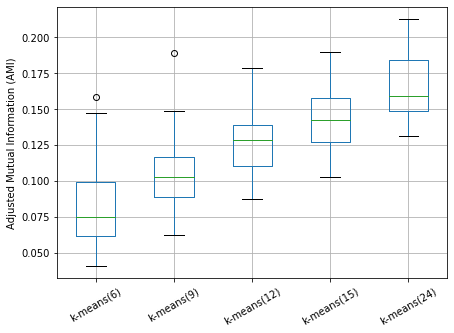

In [45]:
## boxplot AMI results For best embedding
A = []
algo = ['km6','km9','km12','km15','km24']
for a in algo:
    A.append(D[D['algo']==a]['ami'])

B = pd.DataFrame(np.transpose(A), 
                 columns=['k-means(6)','k-means(9)','k-means(12)','k-means(15)',
                          'k-means(24)'])
B.boxplot(rot=30,figsize=(7,5))
plt.ylabel('Adjusted Mutual Information (AMI)');
#plt.savefig('embed_cluster.eps')

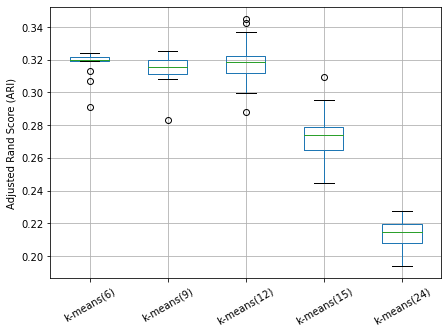

In [57]:
## boxplot ARI results For BEST embedding
A = []
algo = ['km6','km9','km12','km15','km24']
for a in algo:
    A.append(D[D['algo']==a]['ari'])

B = pd.DataFrame(np.transpose(A), 
                 columns=['k-means(6)','k-means(9)','k-means(12)','k-means(15)',
                          'k-means(24)'])
B.boxplot(rot=30,figsize=(7,5))
plt.ylabel('Adjusted Rand Score (ARI)');
#plt.savefig('embed_cluster.eps')

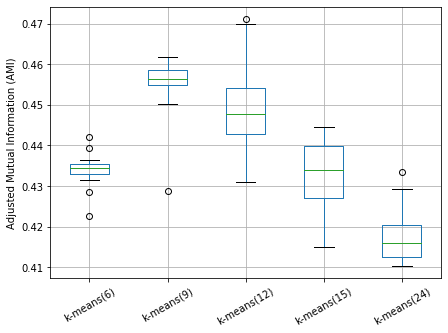

In [54]:
## boxplot AMI results For WORST embedding
A = []
algo = ['km6','km9','km12','km15','km24']
for a in algo:
    A.append(E[E['algo']==a]['ami'])

B = pd.DataFrame(np.transpose(A), 
                 columns=['k-means(6)','k-means(9)','k-means(12)','k-means(15)',
                          'k-means(24)'])
B.boxplot(rot=30,figsize=(7,5))
plt.ylabel('Adjusted Mutual Information (AMI)');
#plt.savefig('embed_cluster.eps')

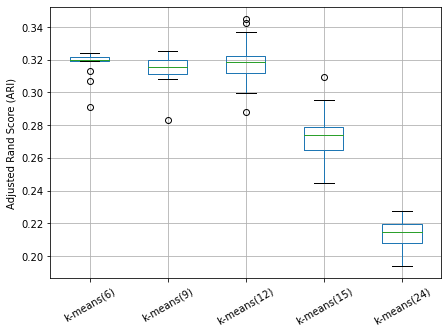

In [56]:
## boxplot ARI results For WORST embedding
A = []
algo = ['km6','km9','km12','km15','km24']
for a in algo:
    A.append(E[E['algo']==a]['ari'])

B = pd.DataFrame(np.transpose(A), 
                 columns=['k-means(6)','k-means(9)','k-means(12)','k-means(15)',
                          'k-means(24)'])
B.boxplot(rot=30,figsize=(7,5))
plt.ylabel('Adjusted Rand Score (ARI)');
#plt.savefig('embed_cluster.eps')

In [62]:
#Question 03
#Generate UMAP and feature extraction
os.system('copy _embed_best _embed')
l = embed2layout()
G.vs['ly'] = [l[int(v['name'])-1] for v in G.vs]
ig.plot(G, layout=G.vs['ly'], bbox=(0,0,300,200))

In [63]:
os.system('copy _embed_worst _embed')
l = embed2layout()
G.vs['ly'] = [l[int(v['name'])-1] for v in G.vs]
ig.plot(G, layout=G.vs['ly'], bbox=(0,0,300,200))

In [64]:
feature_extractor = RecursiveFeatureExtractor(G, max_generations=4)
features = feature_extractor.extract_features()
print(f'\nFeatures extracted from {feature_extractor.generation_count} recursive generations:')
features.head(10)


Features extracted from 3 recursive generations:


degree(mean)(mean)(mean)  degree(mean)(mean)  external_edges(mean)(mean)  \
0                 23.581795           24.286621                  506.991992   
1                 22.940639           21.079037                  433.984222   
2                 23.424620           26.002379                  538.216417   
3                 22.627273           22.946334                  467.747484   
4                 23.740414           23.381818                  494.525421   
5                 22.914267           24.483042                  497.404540   
6                 23.929831           21.706540                  460.016039   
7                 22.905138           23.770719                  482.326733   
8                 22.329996           22.602223                  459.667753   
9                 23.641014           23.945821                  498.709005   

   degree(mean)  external_edges(mean)  internal_edges(mean)  degree  \
0     24.240000            511.920000             47.400000      25   
1     21.250000            405.312500             31.000000      16   
2     23.653846            529.756410             44.320513      78   
3     17.933333            373.200000             29.333333      15   
4     26.714286            565.142857             49.928571      14   
5     20.226415            444.584906             33.377358      53   
6     30.882353            598.294118             60.647059      17   
7     20.675676            436.270270             35.837838      37   
8     19.166667            394.166667             30.333333      12   
9     24.214286            518.428571             42.785714      14   

   internal_edges  external_edges  
0              44             543  
1              18             320  
2             186            1551  
3              16             252  
4              25             338  
5              98             929  
6              25             492  
7              77             648  
8              14             214  
9              17             319

In [65]:
role_extractor = RoleExtractor(n_roles=3)
role_extractor.extract_role_factors(features)
node_roles = role_extractor.roles
role_extractor.role_percentage.head()

role_0    role_1    role_2
0  0.068656  0.265031  0.666312
1  0.016351  0.550468  0.433180
2  0.434223  0.004282  0.561495
3  0.016641  0.645857  0.337502
4  0.344770  0.642216  0.013014

In [66]:
#import seaborn as sns
unique_roles = sorted(set(node_roles.values()))
# uncomment for color plot
# cls = ['red','blue','green']
# map roles to colors
role_colors = {role: cls[i] for i, role in enumerate(unique_roles)}

# store colors for all nodes in G
G.vs()['color'] = [role_colors[node_roles[node]] for node in range(G.vcount())]

## Plot with node labels
G.vs()['size'] = 10
#z.vs()['label'] = [v.index for v in z.vs()]
G.vs()['label_size'] = 0
#ig.plot(z, 'refex.eps', bbox=(0,0,300,300)) 
ig.plot(G, bbox=(0,0,300,300)) 